<a href="https://colab.research.google.com/github/agayev169/pytorch_examples/blob/master/nst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU

In [0]:
!nvidia-smi

Tue Jan  7 10:01:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
from PIL import Image
import numpy as np

## Constants

In [0]:
cont_layers  = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]
last_layer = "conv_5"

device = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE = 256

## Model

### Class

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = self.get_model()


    def get_model(self):
        model = models.vgg16(pretrained=True).eval()
        new_model = nn.Sequential()

        for layer in model.children():
            seq = layer
            break

        i = 0
        for layer in seq:
            if isinstance(layer, nn.Conv2d):
                name = f"conv_{i}"
                i += 1
            elif isinstance(layer, nn.ReLU):
                name = f"relu_{i}"
            elif isinstance(layer, nn.MaxPool2d):
                name = f"pool_{i}"
                
            new_model.add_module(name, layer)
            if name == last_layer:
                break
        
        return new_model

    
    def forward(self, x):
        result = {"cont_layers" : [],
                  "style_layers": []}

        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Sequential):
                continue
            x = layer(x)
            if name in cont_layers:
                result["cont_layers"].append(x)
            if name in style_layers:
                result["style_layers"].append(x)

        return result

In [0]:
def gram_matrix(x):
    a, b, c, d = x.size()
    features = x.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)


def style_loss(src, style):
    a, b, c, d = src.size()
    G = gram_matrix(src)
    return F.mse_loss(G, style)


def cont_loss(src, cont):
    return F.mse_loss(src, cont)


def total_loss(model, src_img, cont_features, style_features, cont_w, style_w):
    out = model(src_img)
    out_cont, out_style = out["cont_layers"], out["style_layers"]

    cont_w = cont_w / len(out_cont)
    c_loss = 0
    for out, target in zip(out_cont, cont_features):
        c_loss += cont_loss(out, target.detach()) * cont_w
    
    style_w = style_w / len(out_style)
    s_loss = 0
    for out, target in zip(out_style, style_features):
        s_loss += style_loss(out, target.detach()) * style_w

    return c_loss + s_loss, c_loss, s_loss

### Train

In [0]:
def train(model, src_img, cont_img, style_img, opt, opt_scheduler=None, cont_weight=1e2, style_weight=1e-1, num_iterations=1000, print_every=100):
    train_begin = time.time()

    cont_loss_hist  = []
    style_loss_hist = []

    cont_features  = model(cont_img)["cont_layers"]
    style_features = model(style_img)["style_layers"]

    for i, feature in enumerate(style_features):
        style_features[i] = gram_matrix(feature)

    src_img.data.clamp_(0, 1)

    for iteration in range(num_iterations):
        iter_begin = time.time()
        opt.zero_grad()

        t_loss, c_loss, s_loss = total_loss(model, 
                                            src_img, 
                                            cont_features,
                                            style_features,
                                            cont_weight,
                                            style_weight)
        t_loss.backward()

        opt.step()

        src_img.data.clamp_(0, 1)

        cont_loss_hist.append(c_loss.item())
        style_loss_hist.append(s_loss.item())

        iter_time = time.time() - iter_begin
        total_time = time.time() - train_begin

        if opt_scheduler:
            opt_scheduler.step(t_loss)
            
        if (iteration + 1) % print_every == 0:
            print(f"{iteration + 1:6d}/{num_iterations:6d} --- \
cont_loss: {c_loss.item():.6f} --- style_loss: \
{s_loss.item():.6f} --- total_loss: \
{t_loss.item():.6f} --- iteration_time: {iter_time:.5f} --- total_time: {total_time:.5f}")
            
    return cont_loss_hist, style_loss_hist

In [0]:
transformer = transforms.Compose([
                                  transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                  transforms.ToTensor()
])

cont_img_path = "/content/drive/My Drive/nst/petite_france.jpg"
style_img_path = "/content/drive/My Drive/nst/style.jpeg"

cont_img  = transformer(Image.open( cont_img_path).convert("RGB")).to(device).view(1, 3, IMG_SIZE, IMG_SIZE)
style_img = transformer(Image.open(style_img_path).convert("RGB")).to(device).view(1, 3, IMG_SIZE, IMG_SIZE)

In [0]:
%%time
src_img = cont_img.clone()
src_img = src_img.requires_grad_(True)

lr           = 0.001
iterations_n = 20000

opt = optim.Adam([src_img], lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=100, verbose=True, min_lr=1e-05, factor=0.5)
model = Model().to(device)
c_loss, s_loss = train(model, src_img, cont_img, style_img, opt, scheduler, 1, 1e10, iterations_n, 500)

   500/ 20000 --- cont_loss: 1.546353 --- style_loss: 1930.633057 --- total_loss: 1932.179443 --- iteration_time: 0.02177 --- total_time: 11.09321
  1000/ 20000 --- cont_loss: 1.696957 --- style_loss: 986.473633 --- total_loss: 988.170593 --- iteration_time: 0.02197 --- total_time: 22.12375
  1500/ 20000 --- cont_loss: 1.788125 --- style_loss: 664.998718 --- total_loss: 666.786865 --- iteration_time: 0.02206 --- total_time: 33.14122
  2000/ 20000 --- cont_loss: 1.856110 --- style_loss: 496.429260 --- total_loss: 498.285370 --- iteration_time: 0.02175 --- total_time: 44.19317
  2500/ 20000 --- cont_loss: 1.911429 --- style_loss: 387.590881 --- total_loss: 389.502319 --- iteration_time: 0.02184 --- total_time: 55.25402
  3000/ 20000 --- cont_loss: 1.958306 --- style_loss: 307.195312 --- total_loss: 309.153625 --- iteration_time: 0.02263 --- total_time: 66.43566
  3500/ 20000 --- cont_loss: 2.000049 --- style_loss: 243.229248 --- total_loss: 245.229294 --- iteration_time: 0.02215 --- tota

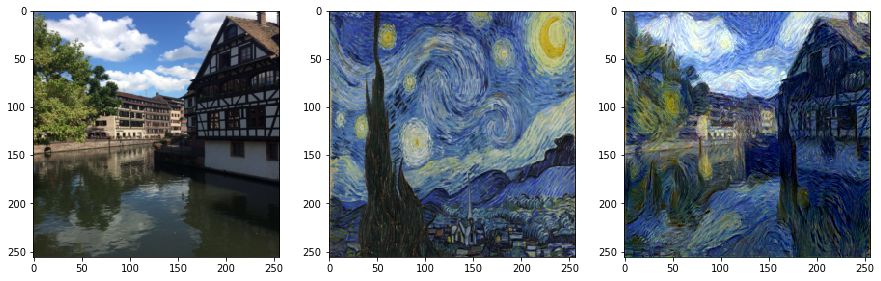

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cont_img.cpu().detach().numpy().reshape(3, IMG_SIZE, IMG_SIZE).transpose((1,2,0)))
ax[1].imshow(style_img.cpu().detach().numpy().reshape(3, IMG_SIZE, IMG_SIZE).transpose((1,2,0)))
ax[2].imshow(src_img.cpu().detach().numpy().reshape(3, IMG_SIZE, IMG_SIZE).transpose((1,2,0)))

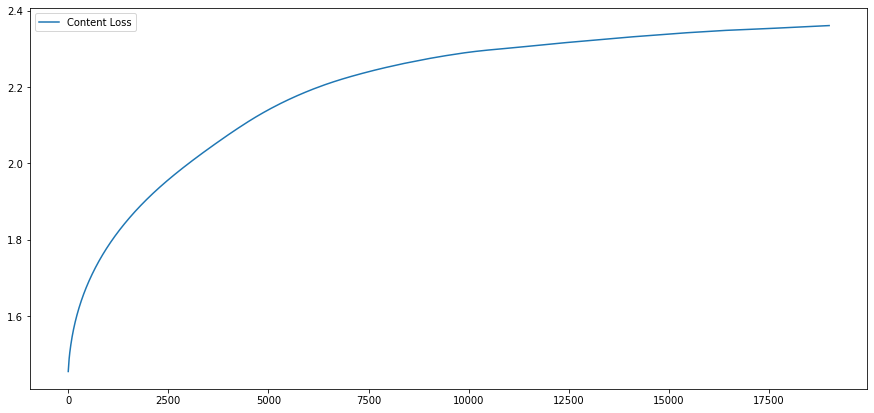

In [0]:
plt.figure(figsize=(15, 7))
plt.plot(np.convolve(c_loss, [1/1000] * 1000, mode="valid"), label="Content Loss")
plt.legend()

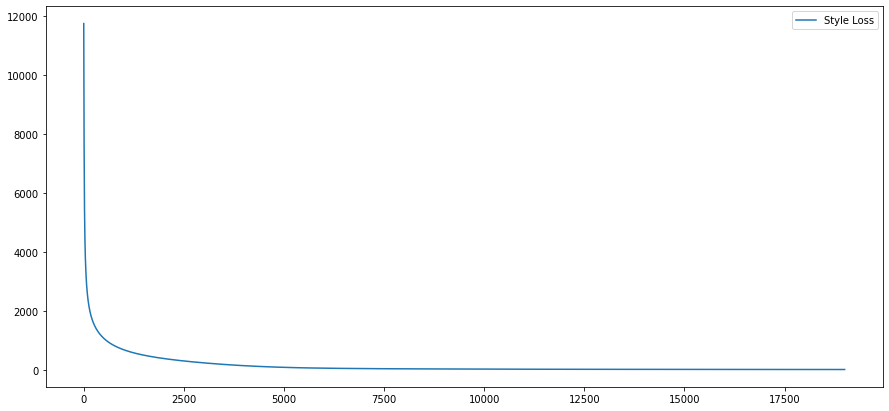

In [0]:
plt.figure(figsize=(15, 7))
plt.plot(np.convolve(s_loss, [1/1000] * 1000, mode="valid"), label="Style Loss")
plt.legend()